# Purpose
Run inference on the converted yolov4 onnx model.
This tutorial also includes preprocess and postprocess steps. 

## Step 1: Preprocess

In [1]:
import cv2
import numpy as np

def image_preprocess(image, target_size, gt_boxes=None):

    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes

In [2]:
input_size = 416

original_image = cv2.imread("kite.jpg")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]

image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

print("Preprocessed image shape:",image_data.shape) # shape of the preprocessed input

Preprocessed image shape: (1, 416, 416, 3)


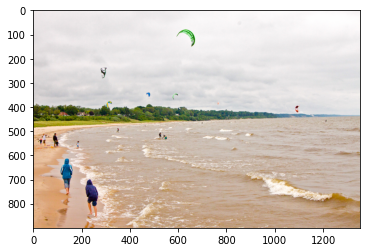

In [3]:
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(np.asarray(original_image))

## Step 2 (optional): Save the preprocessed image in TensorProto format

In [4]:
from onnx import numpy_helper
import onnx
import os

data_dir = "./test_data_set"
test_data_dir = os.path.join(data_dir)
if not os.path.exists(test_data_dir):
    os.makedirs(test_data_dir)
        
# Convert the Numpy array to a TensorProto
tensor = numpy_helper.from_array(image_data)
# print('TensorProto:\n{}'.format(tensor))

# Save the TensorProto
with open(os.path.join(test_data_dir, "input1.pb"), 'wb') as f:
    f.write(tensor.SerializeToString())

## Step 3: Inference

In [5]:
import onnxruntime as rt
sess = rt.InferenceSession("model.onnx")

output_name = sess.get_outputs()[0].name
input_name = sess.get_inputs()[0].name

detections = sess.run([output_name], {input_name: image_data})[0]
print("Output shape:", detections.shape)

Output shape: (1, 52, 52, 3, 85)


## Step 4 (optional): Save the preprocessed image in TensorProto format
Using the same process as above.

In [6]:
from onnx import numpy_helper
import onnx
import os

data_dir = "./test_data_set"
test_data_dir = os.path.join(data_dir)
if not os.path.exists(test_data_dir):
    os.makedirs(test_data_dir)
        
# Convert the Numpy array to a TensorProto
tensor = numpy_helper.from_array(image_data)
# print('TensorProto:\n{}'.format(tensor))

# Save the TensorProto
with open(os.path.join(test_data_dir, "output1.pb"), 'wb') as f:
    f.write(tensor.SerializeToString())

## Step 5: Postprocess output
Please download the [core](https://github.com/hunglc007/tensorflow-yolov4-tflite/tree/master/core) and [data](https://github.com/hunglc007/tensorflow-yolov4-tflite/tree/master/data) folders from hunglc007/tensorflow-yolov4-tflite.

In [7]:
from core.config import cfg
import core.utils as utils
from PIL import Image
from matplotlib.pyplot import imshow

In [8]:
ANCHORS = utils.get_anchors(cfg.YOLO.ANCHORS)
STRIDES = np.array(cfg.YOLO.STRIDES)
XYSCALE = cfg.YOLO.XYSCALE

pred_bbox = utils.postprocess_bbbox(np.expand_dims(detections, axis=0), ANCHORS, STRIDES, XYSCALE)
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.25)
bboxes = utils.nms(bboxes, 0.213, method='nms')
image = utils.draw_bbox(original_image, bboxes)

## Step 6: Show the image output

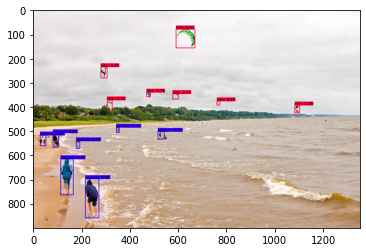

In [9]:
image = Image.fromarray(image)
image.show()

%matplotlib inline
imshow(np.asarray(image))